In [23]:
import pandas as pd
from IPython.display import display, HTML

%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
dataset1 = pd.read_pickle('./train_dataset_unsyn_1.pkl')
dataset2 = pd.read_pickle('./train_dataset_unsyn_large2.pkl')
dataset3 = pd.read_pickle('./train_dataset_unsyn_beta1.5_100.pkl')
dataset = pd.concat([dataset1, dataset2, dataset3])

In [25]:
print(len(dataset))

10900


In [26]:
x = dataset.filter(regex='x')
y = dataset.filter(regex='y')

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# 200 testing samples and 700 validation samples
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=200, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=700, random_state=42)

In [29]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10000, 100)
(200, 100)
(10000, 100)
(200, 100)


In [30]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [31]:
dataset

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y90,y91,y92,y93,y94,y95,y96,y97,y98,y99
0,1,62,57,62,64,64,66,62,63,60,...,98,99,99,99,99,98,99,98,98,99
1,1,44,45,35,33,38,45,35,33,35,...,98,98,98,98,99,99,99,99,98,99
2,1,32,16,23,25,24,15,26,17,26,...,98,97,98,98,96,99,99,98,98,97
3,1,22,6,8,16,28,23,10,6,9,...,50,71,68,66,59,69,66,64,53,77
4,1,16,6,2,2,4,3,3,20,35,...,16,39,24,24,17,14,11,30,76,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,1,6,0,0,6,0,0,0,0,0,...,0,3,3,0,0,0,2,0,0,0
896,1,6,0,0,6,0,0,0,0,0,...,0,0,3,3,0,0,0,2,0,0
897,1,6,0,0,6,0,0,0,0,0,...,0,0,3,3,0,0,0,2,0,0
898,1,6,0,0,6,0,0,0,0,0,...,0,0,0,3,2,0,0,0,1,0


In [32]:
N = 100
x_dense_train = x_train/N
x_dense_test = x_test/N
x_dense_val = x_val/N
y_dense_train = y_train/N
y_dense_test = y_test/N
y_dense_val = y_val/N

In [33]:
y_dense_test

array([[0.72, 0.97, 0.97, ..., 0.97, 0.97, 0.97],
       [0.38, 0.99, 0.99, ..., 0.98, 1.  , 0.99],
       [0.21, 0.96, 0.85, ..., 0.78, 0.8 , 0.76],
       ...,
       [0.7 , 0.98, 0.98, ..., 0.98, 0.98, 0.98],
       [0.17, 0.89, 0.88, ..., 0.49, 0.53, 0.65],
       [0.21, 0.94, 0.58, ..., 0.58, 0.51, 0.61]])

# MLP

In [34]:
import torch
import torch.nn as nn    
class MLPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(), 
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 80),
            nn.ReLU(),
            nn.Linear(80, 40),
            nn.ReLU(),
            nn.Linear(40, 80),
            nn.ReLU(),
            nn.Linear(80, 100),
        )
    def forward(self, input_tensor):
        return self.model(input_tensor)

In [35]:
x_dense_train = torch.from_numpy(x_dense_train).float()
y_dense_train = torch.from_numpy(y_dense_train).float()
x_dense_test = torch.from_numpy(x_dense_test).float()
y_dense_test = torch.from_numpy(y_dense_test).float()
x_dense_val = torch.from_numpy(x_dense_val).float()
y_dense_val = torch.from_numpy(y_dense_val).float()

## start training here

In [36]:
model = MLPModel()
best_model = None
lowest_val = float('inf')

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
epochs = 3000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
for t in range(epochs):
    y_pred = model(x_dense_train)
    loss = loss_fn(y_pred, y_dense_train)

    y_pred_val = model(x_dense_val)
    val_loss = loss_fn(y_pred_val, y_dense_val)
    if val_loss < lowest_val:
        best_model = copy.deepcopy(model)
        lowest_val = val_loss
    if t%100 == 0:
#         print(t, loss.item())
        print(t, loss.item(), val_loss.item())
    
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 633344.5625 43977.60546875
100 22526.681640625 1532.3746337890625
200 16638.572265625 1134.6248779296875
300 16238.955078125 1109.7357177734375
400 16157.142578125 1106.390380859375


### test the just trained model

In [15]:
y_dense_pred = best_model(x_dense_test)

In [16]:
y_pred = y_dense_pred * N
y_pred = y_pred.detach().numpy()

In [17]:
y_pred_calib = np.maximum(y_pred, 0)

## randomly pick a test sample

In [18]:
i = 2
print(y_pred_calib[i,:] - y_test[i,:]) # error
print(y_test[i,:]) # ground truth
print(y_pred_calib[i,:]) # prediction

[ 2.09707069e+00  2.27320862e+00 -2.22267151e-01  7.96559143e+00
 -1.23410034e+00 -1.69363403e+00  1.19455719e+00 -1.22530136e+01
 -9.39976501e+00 -2.91560364e+00  1.32529526e+01  3.88314819e+00
  1.18067169e+00 -3.13333130e+00 -5.73217773e+00  2.27542877e+00
 -1.52653275e+01 -6.56196594e+00  1.68495255e+01  6.64173889e+00
 -5.62516022e+00  7.76025391e+00  3.27363586e+00 -7.97074890e+00
 -9.48184967e+00 -1.27011032e+01  4.99807739e+00 -1.51573257e+01
  1.84815216e+00 -6.34575653e+00 -1.06411362e+01  2.07656097e+00
 -9.06608582e-01  2.22399902e+00 -4.74799347e+00 -7.11099243e+00
 -3.91963959e+00 -1.48285980e+01  4.64202118e+00 -1.30558243e+01
 -1.33444595e+01 -1.04691849e+01  2.05284119e+00  2.06985474e-02
 -9.42742920e+00  1.60784912e+00  3.30444336e-01 -1.05615845e+01
 -5.05912781e-01  3.04549408e+00  3.57393646e+00 -9.90670776e+00
 -2.03686829e+01 -8.27120972e+00 -1.90863037e+00 -5.70922089e+00
 -2.10502625e+00 -2.86706543e+00 -3.78028870e+00  1.99704208e+01
 -8.88106537e+00  1.65412

## sum negative error

In [19]:
error = y_pred_calib - y_test
negative_error = error*(error<0)
sum_neg_error = np.sum(negative_error, axis=1)
print(sum_neg_error.shape)
print(sum_neg_error.mean())
# print(sum_neg_error)

(200,)
-237.91376946747303


## see mean absolute error

In [20]:
abs_error = abs(y_pred_calib - y_test)
mean_abs_error = np.mean(abs_error, axis=1)
mean_density_test = np.mean(y_test, axis=1)
# print(mean_abs_error)

<Figure size 432x288 with 0 Axes>

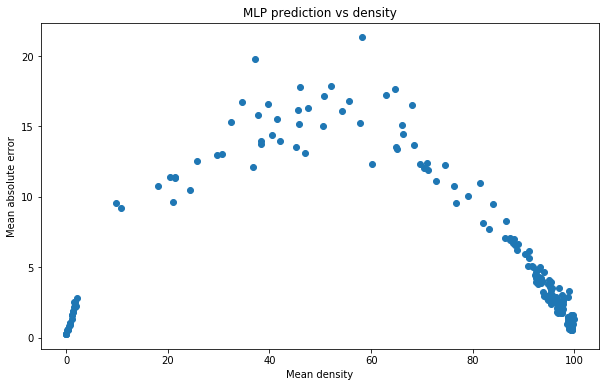

In [21]:
import matplotlib.pyplot as plt
plt.clf()
fig = plt.figure(figsize=(10,6))
plt.plot(mean_density_test, mean_abs_error, 'o')
plt.xlabel('Mean density')
plt.ylabel('Mean absolute error')
plt.title('MLP prediction vs density')
plt.rc('font', size=25)  
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()

In [22]:
rmse2 = np.sqrt(np.mean((y_test-y_pred_calib)**2, axis=1))
print(len(rmse2))
print(np.mean(rmse2))
print(rmse2)

200
10.358800189425779
[16.78768886  1.2896951  14.12208594  9.7069686  13.60489859 20.43912412
 15.98519516 13.47782815  9.77805075  1.62731654 13.8941228   9.85294536
  1.22100651  9.56400165  9.91525668  9.66940042  1.24304206  1.5143478
 10.02980038 22.51301194 14.29131001 10.14946583 16.69512771 21.40907992
  3.53114427 25.44842127  9.84327073  0.93275646 12.25851479 15.5851951
 13.62807265  2.41552643  7.06252792 15.66679102  0.94328695  0.92242755
  1.76834236 16.74504452 15.73759613 17.72853873  2.78201685  9.79808606
  0.71075771  0.42777727 13.66648307  9.83436015 20.56779054 12.35637598
 18.17247296 16.31050856 19.94262576 17.12534555  9.74651144 13.42206151
 19.49326629  0.69649847 18.84731525  0.69737046  3.70274282 16.48294798
 17.06898338 20.27237523  7.90344675  9.9284154  14.26555595 13.79657699
  0.74477793  2.8782768  14.9716116   0.86217141 13.82158021  2.41840327
  1.324154   20.84461231  1.40558039  8.4491665   1.78285637  6.01788902
  3.25189938  1.5584426  16.14

## save model if it is good

In [188]:
torch.save(best_model.state_dict(), 'model_err_10.mdl')

<Figure size 432x288 with 0 Axes>

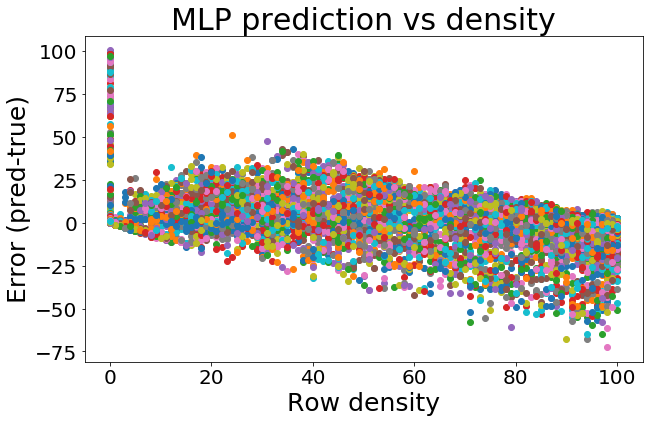

In [189]:
err_mat = y_pred_calib - y_test
err_vec = err_mat.reshape(1, -1)
density_vec = y_test.reshape(1, -1)

import matplotlib.pyplot as plt
plt.clf()
fig = plt.figure(figsize=(10,6))
plt.plot(density_vec, err_vec, 'o')
plt.xlabel('Row density')
plt.ylabel('Error (pred-true)')
plt.title('MLP prediction vs density')
plt.rc('font', size=25)  
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()